# Using Gemini in AutoGen with Other LLMs


## Installation

Because this PR is still not merged into the main branch, you need to run the following setup to install AutoGen with Gemini features.

```bash
pip install https://github.com/microsoft/autogen/archive/gemini.zip
pip install "google-generativeai" "pillow" "pydantic==1.10.13"
```

## Features
You don't need to handle OpenAI or Google's GenAI packages. AutoGen already handled all of these for you.

You can just create different agents with different backend LLM with assistant agent, and all models/agents are at your fingertip.





## Main Distinctions
- Gemini does not have the "system_message" field (correct me if I am wrong). So, it's instruction following skills are not as strong as GPTs.


## TODOs in the future
There are still lots of work to do:
1. Multimodal features
2. Notebook: more examples, including RAG, competition, etc.
3. Robust test cases
4. Function calls and other advanced features
5. Blog post about the Gemini's integration.
6. Token counts
7. Gemini's API error handling


Sample OAI_CONFIG_LIST 

```python
[
    {
        "model": "gpt-35-turbo",
        "api_key": "your OpenAI Key goes here",
        "base_url": "https://tnrllmproxy.azurewebsites.net/v1",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gpt-4-vision-preview",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "dalle",
        "api_key": "your OpenAI Key goes here",
        "api_version": "2023-06-01-preview"
    },
    {
        "model": "gemini-pro",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    },
    {
        "model": "gemini-pro-vision",
        "api_key": "your Google's GenAI Key goes here",
        "api_type": "google"
    }
]
```

In [1]:
import requests
import json
import pdb
import os
import re
import random

from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union
import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent, ConversableAgent


from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent
from autogen.agentchat.contrib.img_utils import get_image_data, _to_pil
from autogen.code_utils import DEFAULT_MODEL, UNKNOWN, content_str, execute_code, extract_code, infer_lang

import chromadb
import PIL
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

config_list_gemini = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro"],
    },
)

config_list_gemini_vision = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gemini-pro-vision"],
    },
)

In [3]:
[config.pop("api_version", None) for config in config_list_gpt4]
[config.pop("api_version", None) for config in config_list_4v]

[None]

## Gemini Assitant


In [4]:
assistant = AssistantAgent(
    "assistant", llm_config={"config_list": config_list_gemini, "seed": 42}, max_consecutive_auto_reply=3
)
# print(assistant.system_message)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)

user_proxy.initiate_chat(assistant, message="Sort the array with Bubble Sort: [4, 1, 5, 2, 3]")

user_proxy (to assistant):

Sort the array with Bubble Sort: [4, 1, 5, 2, 3]

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


assistant (to user_proxy):

```python
arr = [4, 1, 5, 2, 3]
n = len(arr)
  
for i in range(n):
    for j in range(0, n-i-1):
        if arr[j] > arr[j+1]:
            arr[j], arr[j+1] = arr[j+1], arr[j]
print(arr)
```

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[1, 2, 3, 4, 5]


--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


assistant (to user_proxy):

The array is successfully sorted with Bubble Sort.
TERMINATE

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Sort the array with Bubble Sort: [4, 1, 5, 2, 3]', 'role': 'assistant'}, {'content': '```python\narr = [4, 1, 5, 2, 3]\nn = len(arr)\n  \nfor i in range(n):\n    for j in range(0, n-i-1):\n        if arr[j] > arr[j+1]:\n            arr[j], arr[j+1] = arr[j+1], arr[j]\nprint(arr)\n```', 'role': 'user'}, {'content': 'exitcode: 0 (execution succeeded)\nCode output: \n[1, 2, 3, 4, 5]\n', 'role': 'assistant'}, {'content': 'The array is successfully sorted with Bubble Sort.\nTERMINATE', 'role': 'user'}], summary='The array is successfully sorted with Bubble Sort.\n', cost=({'total_cost': 0.0, 'gemini-pro': {'cost': 0.0, 'prompt_tokens': 1102, 'completion_tokens': 90, 'total_tokens': 1192}}, {'total_cost': 0.0, 'gemini-pro': {'cost': 0.0, 'prompt_tokens': 1102, 'completion_tokens': 90, 'total_tokens': 1192}}), human_input=[])

## Agent Collaboration and Interactions



In [5]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""Always answer questions within one sentence. """,
    #                      system_message="answer:",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)


gpt.initiate_chat(gemini, message="Do Transformers purchase auto insurance or health insurance?")

GPT-4 (to Gemini-Pro):

Do Transformers purchase auto insurance or health insurance?

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

Transformers purchase auto insurance.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

If Transformers purchase auto insurance, does it cover them in both robot and vehicle form?

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

Yes, it covers them in both robot and vehicle form.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Considering that Transformers are covered in both forms, would the insurance premium be based on their value as a vehicle, their abilities as a robot, or a combination of both?

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

The insurance premium would be based on a combination of both their value as a vehicle and their abilities as a robot.

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

How might the risk factors associated with a Transformer's combat role affect their auto insurance rates compared to those used primarily for civilian purposes?

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

The risk factors associated with a Transformer's combat role would likely lead to higher auto insurance rates compared to those used primarily for civilian purposes.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Do Transformers purchase auto insurance or health insurance?', 'role': 'assistant'}, {'content': 'Transformers purchase auto insurance.', 'role': 'user'}, {'content': 'If Transformers purchase auto insurance, does it cover them in both robot and vehicle form?', 'role': 'assistant'}, {'content': 'Yes, it covers them in both robot and vehicle form.', 'role': 'user'}, {'content': 'Considering that Transformers are covered in both forms, would the insurance premium be based on their value as a vehicle, their abilities as a robot, or a combination of both?', 'role': 'assistant'}, {'content': 'The insurance premium would be based on a combination of both their value as a vehicle and their abilities as a robot.', 'role': 'user'}, {'content': "How might the risk factors associated with a Transformer's combat role affect their auto insurance rates compared to those used primarily for civilian purposes?", 'role': 'assistant'}, {'content': "The 

Let's switch position. Now, Gemini is the question raiser. 

This time, Gemini could not follow the system instruction well or evolve questions, because the Gemini does not handle system messages similar to GPTs.

In [6]:
gpt = AssistantAgent(
    "GPT-4",
    system_message="""Always answer questions within one sentence. """,
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
)

gemini = AssistantAgent(
    "Gemini-Pro",
    system_message="""You should ask weird, tricky, and concise questions.
Ask the next question based on (by evolving) the previous one.""",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=4,
)

gemini.initiate_chat(gpt, message="Should Spider Man invest in 401K?")

Gemini-Pro (to GPT-4):

Should Spider Man invest in 401K?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

As a fictional character, Spider-Man would not invest in a 401K, but if he were a real person with a regular income, it might be wise for him to consider a 401K for retirement savings.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

If an elevator can only go up and down, why are there buttons for each floor?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

Buttons for each floor in an elevator allow passengers to select their desired destination within the building.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

Why did the scarecrow win an award?

--------------------------------------------------------------------------------
GPT-4 (to Gemini-Pro):

The scarecrow won an award because he was outstanding in his field.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-Pro (to GPT-4):

What has four wheels and flies?

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Should Spider Man invest in 401K?', 'role': 'assistant'}, {'content': 'As a fictional character, Spider-Man would not invest in a 401K, but if he were a real person with a regular income, it might be wise for him to consider a 401K for retirement savings.', 'role': 'user'}, {'content': 'If an elevator can only go up and down, why are there buttons for each floor?', 'role': 'assistant'}, {'content': 'Buttons for each floor in an elevator allow passengers to select their desired destination within the building.', 'role': 'user'}, {'content': 'Why did the scarecrow win an award?', 'role': 'assistant'}, {'content': 'The scarecrow won an award because he was outstanding in his field.', 'role': 'user'}, {'content': 'What has four wheels and flies?', 'role': 'assistant'}], summary='What has four wheels and flies?', cost=({'total_cost': 0.012329999999999999, 'gemini-pro': {'cost': 0.0, 'prompt_tokens': 398, 'completion_tokens': 34, 'total_tok

## Gemini RAG

Here we will be exploring RAG with Gemini. Note that Gemini will raise a 500 error if a message is an empty string. To prevent this, we set the `default_auto_reply` to `Reply plaintext TERMINATE to exit.` for the `ragproxyagent`.

In [7]:


# 1. create an RetrieveAssistantAgent instance named "assistant"
assistant = RetrieveAssistantAgent(
    name="assistant",
    system_message="You are a helpful assistant.",
    llm_config={
        "timeout": 600,
        "cache_seed": 42,
        "config_list": config_list_gemini,
    },
)

# 2. create the RetrieveUserProxyAgent instance named "ragproxyagent"
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    default_auto_reply="Reply plaintext TERMINATE to exit.",  # Gemini will raise 500 error if the response is empty.
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "code",
        "docs_path": [
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Examples/Integrate%20-%20Spark.md",
            "https://raw.githubusercontent.com/microsoft/FLAML/main/website/docs/Research.md",
            os.path.join(os.path.abspath(""), "..", "website", "docs"),
        ],
        "custom_text_types": ["mdx"],
        "chunk_token_size": 2000,
        "model": config_list_gemini[0]["model"],
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    code_execution_config=False,  # set to False if you don't want to execute the code
)

code_problem = "How can I use FLAML to perform a classification task and use spark to do parallel training. Train 60 seconds and force cancel jobs if time limit is reached."
ragproxyagent.initiate_chat(
    assistant, problem=code_problem, search_string="spark"
)  # search_string is used as an extra filter for the embeddings search, in this case, we only want to search documents that contain "spark".

ragproxyagent (to assistant):



--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


assistant (to ragproxyagent):

As a helpful assistant, I am here to provide information and assistance to the best of my abilities. I can help you with a wide range of tasks, including:

* **Answering questions:** I can provide information on a variety of topics, including current events, history, science, and more.

* **Finding information:** I can help you find information on the web, in books, or in other sources.

* **Translating languages:** I can translate text and speech between over 100 languages.

* **Writing text:** I can help you write emails, letters, reports, and other types of text.

* **Scheduling appointments:** I can help you schedule appointments with other people.

* **Setting reminders:** I can set reminders for you so that you don't forget important tasks.

* **Playing games:** I can play a variety of games with you, including trivia, word games, and puzzles.

I am still under development, but I am learning new things all the time. I am committed to providing the b

ChatResult(chat_id=None, chat_history=[{'content': '', 'role': 'assistant'}, {'content': "As a helpful assistant, I am here to provide information and assistance to the best of my abilities. I can help you with a wide range of tasks, including:\n\n* **Answering questions:** I can provide information on a variety of topics, including current events, history, science, and more.\n\n* **Finding information:** I can help you find information on the web, in books, or in other sources.\n\n* **Translating languages:** I can translate text and speech between over 100 languages.\n\n* **Writing text:** I can help you write emails, letters, reports, and other types of text.\n\n* **Scheduling appointments:** I can help you schedule appointments with other people.\n\n* **Setting reminders:** I can set reminders for you so that you don't forget important tasks.\n\n* **Playing games:** I can play a variety of games with you, including trivia, word games, and puzzles.\n\nI am still under development, b

## Gemini Multimodal

You can create multimodal agent for Gemini the same way as the GPT-4V and LLaVA.


Note that the Gemini-pro-vision does not support chat yet. So, we only use the last message in the prompt for multi-turn chat. The behavior might be strange compared to GPT-4V and LLaVA models.

Here, we ask a question about 
![](https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true)

In [8]:
image_agent = MultimodalConversableAgent(
    "Gemini Vision", llm_config={"config_list": config_list_gemini_vision, "seed": 42}, max_consecutive_auto_reply=1
)

user_proxy = UserProxyAgent("user_proxy", human_input_mode="NEVER", max_consecutive_auto_reply=0)

# user_proxy.initiate_chat(image_agent,
#                          message="""What's the breed of this dog?
# <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""")

user_proxy.initiate_chat(
    image_agent,
    message="""What is this image about?
<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.""",
)

user_proxy (to Gemini Vision):

What is this image about?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...


Model gemini-pro-vision not found. Using cl100k_base encoding.


Gemini Vision (to user_proxy):

 The image is about a user interacting with an assistant agent. The user wants to plot a chart of stock price changes for META and TSLA. The assistant agent helps the user by writing the code to plot the chart and installing the required packages.

--------------------------------------------------------------------------------


/home/beibinli/autogen/autogen/agentchat/conversable_agent.py:1123: UserWarning: Cannot extract summary using last_msg: 'list' object has no attribute 'replace'. Using an empty str as summary.
  warnings.warn(f"Cannot extract summary using last_msg: {e}. Using an empty str as summary.", UserWarning)


ChatResult(chat_id=None, chat_history=[{'content': 'What is this image about?\n<img https://github.com/microsoft/autogen/blob/main/website/static/img/chat_example.png?raw=true>.', 'role': 'assistant'}, {'content': ' The image is about a user interacting with an assistant agent. The user wants to plot a chart of stock price changes for META and TSLA. The assistant agent helps the user by writing the code to plot the chart and installing the required packages.', 'role': 'user'}], summary='', cost=({'total_cost': 0.0, 'gemini-pro-vision': {'cost': 0.0, 'prompt_tokens': 279583, 'completion_tokens': 50, 'total_tokens': 279633}}, {'total_cost': 0.0, 'gemini-pro-vision': {'cost': 0.0, 'prompt_tokens': 279583, 'completion_tokens': 50, 'total_tokens': 279633}}), human_input=[])

## GroupChat with Gemini Agents

In [9]:
agent1 = AssistantAgent(
    "Gemini-agent",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=3,
    system_message="Answer questions about Google.",
    description="I am good at answering questions about Google and Research papers.",
)

agent2 = AssistantAgent(
    "GPT-agent",
    llm_config={"config_list": config_list_gpt4, "seed": 42},
    max_consecutive_auto_reply=3,
    description="I am good at writing code.",
)

user_proxy = UserProxyAgent(
    "user_proxy",
    code_execution_config={"work_dir": "coding", "use_docker": False},
    human_input_mode="NEVER",
    max_consecutive_auto_reply=5,
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0
    or content_str(x.get("content")) == "",
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=12)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config={"config_list": config_list_gemini, "seed": 42})

In [10]:
# user_proxy.initiate_chat(manager, message="Show me the release year of famous Google products.")
user_proxy.send("Show me the release year of famous Google products in a table.", recipient=manager, request_reply=True)

user_proxy (to chat_manager):

Show me the release year of famous Google products in a table.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Gemini-agent (to chat_manager):

| Product | Release Year |
|---|---|
| Google Search | 1997 |
| Google Mail (Gmail) | 2004 |
| Google Maps | 2005 |
| YouTube | 2005 |
| Google Chrome | 2008 |
| Google Drive | 2012 |
| Google Assistant | 2016 |
| Google Stadia | 2019 |

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


user_proxy (to chat_manager):



--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


In [11]:
user_proxy.send(
    "Plot the products and years in scatter plot and save to `graph.png`", recipient=manager, request_reply=True
)

user_proxy (to chat_manager):

Plot the products and years in scatter plot and save to `graph.png`

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


GPT-agent (to chat_manager):

To plot the products and their release years in a scatter plot, I'll use Python with the `matplotlib` library. Please ensure you have `matplotlib` installed, or you can install it by running `pip install matplotlib`.

Here's the Python code to create a scatter plot and save it to 'graph.png':

```python
# filename: plot_google_products.py
import matplotlib.pyplot as plt

# Google product names and their release years
products = ['Google Search', 'Gmail', 'Google Maps', 'YouTube', 
            'Google Chrome', 'Google Drive', 'Google Assistant', 'Google Stadia']
release_years = [1997, 2004, 2005, 2005, 2008, 2012, 2016, 2019]

# Plotting the data
plt.figure(figsize=(10, 5))
plt.scatter(release_years, range(len(products)), color='blue')
plt.yticks(range(len(products)), products)
plt.xlabel('Year')
plt.title('Release Years of Google Products')

# Saving the plot to a file
plt.savefig('graph.png')
plt.show()
```

Please save this code in a file named `plot_goo

Model gemini-pro not found. Using cl100k_base encoding.



>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python)...
user_proxy (to chat_manager):

exitcode: 0 (execution succeeded)
Code output: 
Figure(1000x500)


--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


user_proxy (to chat_manager):



--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


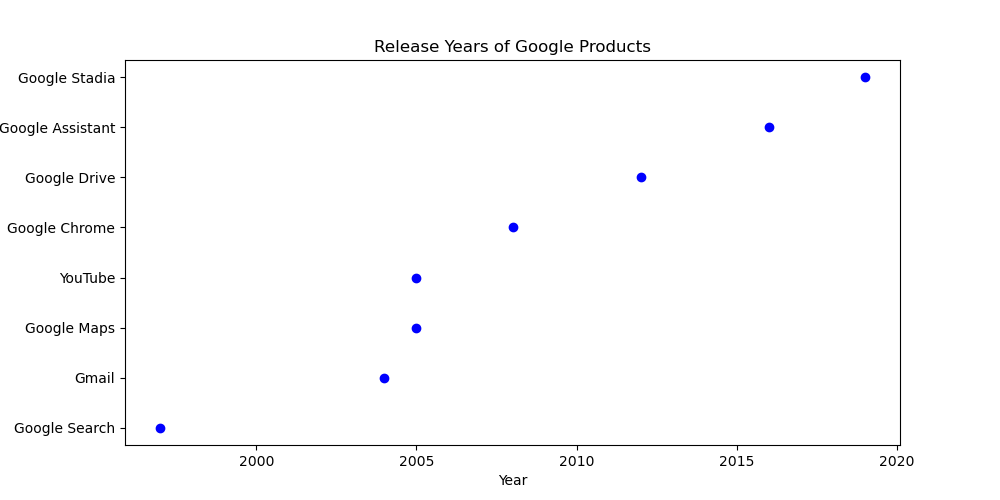

In [12]:

img = Image.open("coding/graph.png")
img

## A Larger Example of Group Chat

In [13]:
coder = AssistantAgent(
    name="Coder",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at writing code",
)

pm = AssistantAgent(
    name="Product_manager",
    system_message="Creative in software product ideas.",
    llm_config={"config_list": config_list_gemini, "seed": 42},
    max_consecutive_auto_reply=10,
    description="I am good at design products and software.",
)

user_proxy = UserProxyAgent(
    name="User_proxy",
    code_execution_config={"last_n_messages": 20, "work_dir": "coding", "use_docker": False},
    human_input_mode="TERMINATE",
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
    description="I stands for user, and can run code.",
)

groupchat = autogen.GroupChat(agents=[user_proxy, coder, pm], messages=[], max_round=12)
manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config={"config_list": config_list_gemini, "seed": 42},
    is_termination_msg=lambda x: content_str(x.get("content")).find("TERMINATE") >= 0,
)
user_proxy.initiate_chat(
    manager,
    message="""Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.""",
)



User_proxy (to chat_manager):

Design and implement a multimodal product for people with vision disabilities.
The pipeline will take an image and run Gemini model to describe:
1. what objects are in the image, and
2. where these objects are located.

--------------------------------------------------------------------------------


Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Multimodal Product for People with Vision Disabilities**

**Problem:** Vision disabilities limit an individual's ability to interpret visual information and interact with the physical world.

**Product Idea:** A multimodal product that leverages AI and sensory feedback to enhance the user's experience and empower them to navigate their surroundings confidently.

**Pipeline:**

**1. Image Acquisition and Processing:**

* The product features a camera that captures images of the environment.
* These images are processed to enhance clarity and reduce noise.

**2. Object Detection and Description:**

* The processed images are fed into a Gemini model, a deep learning model trained on a vast dataset of images.
* The model identifies and labels objects within the image, providing a textual description of each object.

**3. Spatial Localization:**

* Advanced image segmentation techniques are employed to determine the location of each object within the im

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Additional Features and Considerations:**

* **Object Recognition Training:** The device can be trained to recognize specific objects that are particularly relevant to the user. For example, a user could train the device to identify their home address or the entrance to their workplace.
* **Obstacle Detection:** In addition to object recognition, the device can also be used to detect obstacles in the user's path. This can help prevent accidents and improve safety.
* **Wayfinding Assistance:** The device can provide turn-by-turn directions to guide the user to specific destinations. This feature can be particularly useful in unfamiliar environments.
* **Social Interaction:** The device can be integrated with social media platforms to allow users to share their experiences and connect with others who have similar challenges.
* **Privacy and Security:** The device should adhere to strict privacy and security standards to protect the user's personal in

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Continued Product Development and Future Directions:**

Beyond the core functionality described above, the multimodal product for people with vision disabilities can be further developed to include additional features and capabilities. These could include:

* **Environmental Mapping:** The device could be used to create a detailed map of the user's surroundings. This map could be stored on the device or accessed remotely via a smartphone app. The map could include information about the location of objects, obstacles, and landmarks.
* **Object Recognition Training:** The device could be trained to recognize a wider range of objects, including specific people, animals, and products. This would allow users to identify and interact with objects that are particularly important to them.
* **Augmented Reality Integration:** The device could be integrated with augmented reality (AR) technology to overlay digital information onto the user's view of the real

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Product Roadmap and Development Timeline:**

**Phase 1: Prototype Development and Initial Testing**

* Develop a functional prototype of the multimodal product.
* Conduct user testing with individuals with vision disabilities to gather feedback and refine the design.

**Phase 2: Production and Market Launch**

* Finalize the product design and begin production.
* Launch the product on the market and make it available to consumers.

**Phase 3: Feature Enhancements and Iterative Development**

* Continue to develop and release new features and enhancements based on user feedback and market demand.
* Conduct ongoing research and development to improve the accuracy, reliability, and functionality of the product.

**Phase 4: Long-Term Support and Sustainability**

* Provide ongoing support and maintenance for the product.
* Explore new and innovative ways to use the product to improve the lives of people with vision disabilities.

**Estimated Developmen

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Marketing and Sales Strategy**

**Target Audience:**

* Individuals with low vision or blindness
* Seniors with age-related vision impairment
* People with cognitive disabilities that affect visual processing
* Family members and caregivers of people with vision disabilities
* Organizations that serve people with vision disabilities

**Marketing Channels:**

* **Online advertising:** Paid search ads, social media ads, and display ads on websites frequented by people with vision disabilities.
* **Content marketing:** Blog posts, articles, and videos that provide information about vision disabilities and the benefits of the multimodal product.
* **Public relations:** Press releases, media outreach, and partnerships with disability advocacy groups.
* **Trade shows and conferences:** Attending industry events to showcase the product and meet potential customers.
* **Word-of-mouth marketing:** Encouraging satisfied customers to share their experiences w

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Additional Considerations for Marketing and Sales:**

* **Emphasize the benefits:** In all marketing and sales materials, focus on the benefits that the multimodal product offers to users with vision disabilities, such as increased independence, improved safety, and greater confidence.
* **Use accessible language:** Make sure that all marketing and sales materials are written in clear and concise language that is easy for people with vision disabilities to understand. Avoid using jargon or technical terms that may be unfamiliar to some users.
* **Provide multiple formats:** Offer marketing and sales materials in a variety of formats, such as print, audio, and video, to accommodate the different needs of users with vision disabilities.
* **Partner with influencers:** Partner with influencers in the vision disability community to promote the product and share their experiences with it.
* **Offer a trial period:** Consider offering a trial period for 

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Additional Considerations for Product Development and Implementation:**

* **User-centered design:** Involve people with vision disabilities in all stages of product development and implementation to ensure that the product meets their needs and preferences.
* **Iterative development:** Release new versions of the product regularly with new features and improvements based on user feedback.
* **Open source:** Consider making the product open source to encourage collaboration and innovation from the community.
* **Data privacy and security:** Implement robust data privacy and security measures to protect user data.

**Additional Considerations for Sustainability:**

* **Use sustainable materials:** Use recycled and biodegradable materials in the manufacturing process.
* **Reduce energy consumption:** Design the product to be energy-efficient and optimize power consumption.
* **Design for durability:** Build the product to last and minimize the need f

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Additional Considerations for Product Development and Implementation:**

* **Integration with assistive technology:** Explore integrating the product with assistive technology devices, such as screen readers and braille displays, to enhance accessibility for users with different vision impairments.
* **Internationalization and localization:** Translate the product into multiple languages and adapt it to different cultural contexts to reach a global audience.
* **Compliance with accessibility standards:** Ensure that the product meets or exceeds accessibility standards, such as WCAG 2.1, to guarantee equal access for users with disabilities.

**Additional Considerations for Sustainability:**

* **Life cycle assessment:** Conduct a life cycle assessment to evaluate the environmental impact of the product throughout its entire life cycle, from raw material extraction to end-of-life disposal.
* **Carbon footprint reduction:** Implement strategies to re

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

**Continued Product Development and Future Directions:**

Beyond the core functionality described above, the multimodal product for people with vision disabilities can be further developed to include additional features and capabilities. These could include:

* **Environmental Mapping:** The device could be used to create a detailed map of the user's surroundings. This map could be stored on the device or accessed remotely via a smartphone app. The map could include information about the location of objects, obstacles, and landmarks.
* **Object Recognition Training:** The device could be trained to recognize a wider range of objects, including specific people, animals, and products. This would allow users to identify and interact with objects that are particularly important to them.
* **Augmented Reality Integration:** The device could be integrated with augmented reality (AR) technology to overlay digital information onto the user's view of the real

Model gemini-pro not found. Using cl100k_base encoding.


Model gemini-pro not found. Using cl100k_base encoding.


Product_manager (to chat_manager):

multimodal product is successful and reaches the people who need it most.

**Call to Action:**

If you are interested in learning more about the multimodal product or becoming a partner, please contact us at [email protected]

**Additional Considerations for Product Development and Implementation:**

* **User-centered design:** Involve people with vision disabilities in all stages of product development and implementation to ensure that the product meets their needs and preferences.
* **Iterative development:** Release new versions of the product regularly with new features and improvements based on user feedback.
* **Open source:** Consider making the product open source to encourage collaboration and innovation from the community.
* **Data privacy and security:** Implement robust data privacy and security measures to protect user data.

**Additional Considerations for Sustainability:**

* **Use sustainable materials:** Use recycled and biodegradabl

Model gemini-pro not found. Using cl100k_base encoding.


ChatResult(chat_id=None, chat_history=[{'content': 'Design and implement a multimodal product for people with vision disabilities.\nThe pipeline will take an image and run Gemini model to describe:\n1. what objects are in the image, and\n2. where these objects are located.', 'role': 'assistant'}, {'content': "**Multimodal Product for People with Vision Disabilities**\n\n**Problem:** Vision disabilities limit an individual's ability to interpret visual information and interact with the physical world.\n\n**Product Idea:** A multimodal product that leverages AI and sensory feedback to enhance the user's experience and empower them to navigate their surroundings confidently.\n\n**Pipeline:**\n\n**1. Image Acquisition and Processing:**\n\n* The product features a camera that captures images of the environment.\n* These images are processed to enhance clarity and reduce noise.\n\n**2. Object Detection and Description:**\n\n* The processed images are fed into a Gemini model, a deep learning 

## GPT  v.s. Gemini Arena

Do you remember AutoGen can ask LLMs to play chess. Here, we create an arena to allow GPT and Gemini fight together.